## Assignment 2

In [ ]:


# Install h5py if not already installed.
# The GalaxiesML dataset is stored in HDF5 format, so we need this library to read the data files.

import h5py
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import gdown
import torch.optim as optim
import copy

# URL of the shared Google Drive folder
# folder_url = 'https://drive.google.com/drive/folders/1oeYTxEuQ2aVb5HyK1TdcG0gRk_rChaVk?usp=sharing'

# Download the folder
# gdown.download_folder(folder_url, quiet=False, use_cookies=False)

# URL of the shared Google Drive folder
folder_url = 'https://drive.google.com/drive/folders/1oeYTxEuQ2aVb5HyK1TdcG0gRk_rChaVk?usp=sharing'

# Download the folder
#gdown.download_folder(folder_url, quiet=False, use_cookies=False)

file_path = "./assignment2/small_training_dataset.hdf5"



# Open the file and list all dataset keys
with h5py.File(file_path, "r") as f:
    print("Available keys (datasets) in the file:", list(f.keys()))
    images = f["image"][:, :3, :, :] # Select all images, first 3 channels (g, r, i), 64x64 pixels
    targets = f["specz_redshift"][:] # Load the spectroscopic redshift targets

Available keys (datasets) in the file: ['coord', 'dec', 'g_central_image_pop_10px_rad', 'g_central_image_pop_15px_rad', 'g_central_image_pop_5px_rad', 'g_cmodel_mag', 'g_cmodel_magsigma', 'g_ellipticity', 'g_half_light_radius', 'g_isophotal_area', 'g_major_axis', 'g_minor_axis', 'g_peak_surface_brightness', 'g_petro_rad', 'g_pos_angle', 'g_sersic_index', 'i_central_image_pop_10px_rad', 'i_central_image_pop_15px_rad', 'i_central_image_pop_5px_rad', 'i_cmodel_mag', 'i_cmodel_magsigma', 'i_ellipticity', 'i_half_light_radius', 'i_isophotal_area', 'i_major_axis', 'i_minor_axis', 'i_peak_surface_brightness', 'i_petro_rad', 'i_pos_angle', 'i_sersic_index', 'image', 'object_id', 'r_central_image_pop_10px_rad', 'r_central_image_pop_15px_rad', 'r_central_image_pop_5px_rad', 'r_cmodel_mag', 'r_cmodel_magsigma', 'r_ellipticity', 'r_half_light_radius', 'r_isophotal_area', 'r_major_axis', 'r_minor_axis', 'r_peak_surface_brightness', 'r_petro_rad', 'r_pos_angle', 'r_sersic_index', 'ra', 'skymap_id', 

In [ ]:
# Compute per-channel percentiles based on pixel values
# First, flatten the pixels per channel
pixel_values = [images[:, c, :, :].flatten() for c in range(3)]
# Compute robust bounds using the 0.05th and 99.95th percentiles
percentile_min = [np.percentile(pixel_values[c], 1.) for c in range(3)]
percentile_max = [np.percentile(pixel_values[c], 99.) for c in range(3)]
y_mean = np.mean(targets)
y_std = np.std(targets)

del pixel_values # Delete to free up memory and stay within Colab's limits.

def preprocess_images(images, percentile_min, percentile_max):
    """
    For each channel:
    1. Clip values below the min percentile and above the max percentile.
    2. Apply min-max scaling so that the resulting values are in [0,1].
    """
    # Make a copy so the original images are not modified
    #images = images.copy()

    # For each of the 3 channels, clip then scale
    for c in range(3):
        # Clip to the robust range
        images[c, :, :] = np.clip(images[c, :, :], percentile_min[c], percentile_max[c])
        # Min-max scaling using the clipped range
        images[c, :, :] = (images[c, :, :] - percentile_min[c]) / (percentile_max[c] - percentile_min[c])
    # In this problem, feel free to explore other scaling
    return images

def preprocess_batch(images_batch, percentile_min, percentile_max):
    """
    Apply preprocess_images to each image in a batch.
    images_batch: NumPy array of shape (N, 3, H, W)
    Returns an array of the same shape with each image preprocessed.
    """
    # Create an output array
    preprocessed = np.empty_like(images_batch)
    N = images_batch.shape[0]
    for i in range(N):
        preprocessed[i] = preprocess_images(images_batch[i], percentile_min, percentile_max)
    return preprocessed

In [ ]:
# Preprocess the images
preprocessed_images = preprocess_batch(images, percentile_min, percentile_max)

# Print new min and max for each channel to verify that scaling is in [0,1]
print("New pixel value ranges per channel after clipping & scaling:")
channel_values = []
for c in range(3):
    channel_values.append(preprocessed_images[:, c, :, :].flatten())
    print(f"Channel {c+1}: min = {np.min(channel_values[c]):.4f}, max = {np.max(channel_values[c]):.4f}")

New pixel value ranges per channel after clipping & scaling:
Channel 1: min = 0.0000, max = 1.0000
Channel 2: min = 0.0000, max = 1.0000
Channel 3: min = 0.0000, max = 1.0000


In [ ]:
class GalaxyDataset(Dataset):
    def __init__(self, hdf5_file, target_key="specz_redshift", transform=None, normalize_target=True, pix_min = percentile_min, pix_max = percentile_max, y_mean = y_mean, y_std= y_std):
        self.hdf5_file = hdf5_file
        self.target_key = target_key
        self.transform = transform  # Store transform
        self.normalize_target = normalize_target  # Enable/Disable target normalization
        self.percentile_min, self.percentile_max = pix_min, pix_max
        self.target_mean, self.target_std = y_mean, y_std

        # Open file once, but don't load the entire dataset
        with h5py.File(self.hdf5_file, "r") as f:
            self.dataset_length = len(f["image"])  # Get number of samples

    def __len__(self):
        return self.dataset_length

    def __getitem__(self, idx):
        with h5py.File(self.hdf5_file, "r") as f:
            # images have five imaging filters g (blue), r (red), i (infrared), z (deep infrared), y (very deep infrared)
            image = f["image"][idx, :3, :, :]  # Load only first 3 channels
            # the spectroscopic redshift is the target
            target = f[self.target_key][idx]

        # Normalize the image per-channel
        image = preprocess_images(image, self.percentile_min, self.percentile_max)

        # Normalize target using computed mean/std
        target = (target - self.target_mean) / self.target_std

        return torch.tensor(image, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

In [ ]:
training_dataset_path = "assignment2/small_training_dataset.hdf5"
validation_dataset_path = "assignment2/small_validation_dataset.hdf5"
testing_dataset_path = "assignment2/small_testing_dataset.hdf5"

# Create dataset instances
train_transform = None  # We'll define this later if needed
train_dataset = GalaxyDataset(training_dataset_path, transform=train_transform)
val_dataset = GalaxyDataset(validation_dataset_path)
test_dataset = GalaxyDataset(testing_dataset_path)

# Use DataLoader for efficient batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Check if DataLoader is working
for images, targets in train_loader:
    print(f"Batch shape: {images.shape}, Targets shape: {targets.shape}")
    break # Check only one batch



Batch shape: torch.Size([32, 3, 64, 64]), Targets shape: torch.Size([32])


0.0 0.3019585


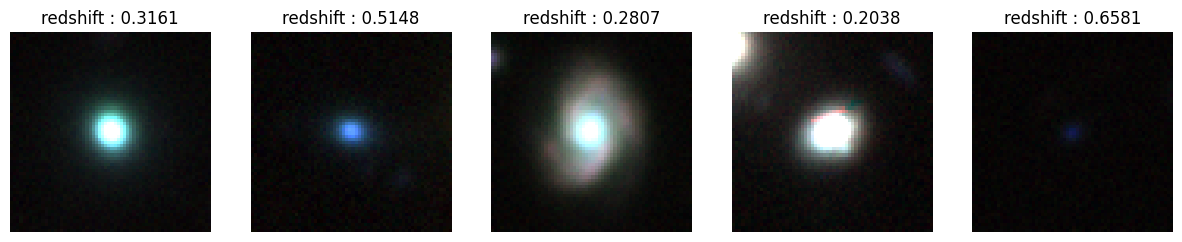

In [ ]:
import matplotlib.pyplot as plt

# Function to display 5 sample images from DataLoader
def show_sample_images(data_loader, num_samples=5):
    # Get a batch of images
    images, targets = next(iter(data_loader))  # Fetch one batch
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i in range(num_samples):
        image = images[i]  # Get image tensor (3,64,64)
        target = targets[i]  # Get target tensor

        # Convert from (3,64,64) to (64,64,3) for visualization
        image = image.permute(1, 2, 0).numpy()
        # Clip values to [0,1] to avoid display issues
        #image = np.clip(image, 0, 1)
        axes[i].imshow(image)
        axes[i].set_title(f"redshift : {target.item()*y_std + y_mean:.4f}")
        axes[i].axis("off")
    print(np.min(image), np.max(image))

    plt.show()

# Show 5 sample images from DataLoader
show_sample_images(train_loader)

### Question 1

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class GalaxyRedshiftCNN(nn.Module):
    def __init__(self):
        super(GalaxyRedshiftCNN, self).__init__()

        # First convolutional block
        # Input: (batch_size, 3, 64, 64)
        # Output: (batch_size, 32, 32, 32)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional block
        # Input: (batch_size, 32, 32, 32)
        # Output: (batch_size, 64, 16, 16)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third convolutional block
        # Input: (batch_size, 64, 16, 16)
        # Output: (batch_size, 128, 8, 8)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        # Input: (batch_size, 128*8*8)
        # Output: (batch_size, 256)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.relu4 = nn.ReLU()

        # Output layer
        # Input: (batch_size, 256)
        # Output: (batch_size, 1)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        # First block
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Second block
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Third block
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        # Flatten
        x = self.flatten(x)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)

        # Return the predicted redshift
        return x

In [ ]:
# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = GalaxyRedshiftCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define training function
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    # Lists to store metrics
    train_losses = []
    val_losses = []

    # Best validation loss and corresponding model
    best_val_loss = float('inf')
    best_model_weights = None

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        for images, targets in train_loader:
            images, targets = images.to(device), targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Reshape targets to match outputs
            targets = targets.view(-1, 1)

            # Calculate loss
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update running loss
            running_loss += loss.item() * images.size(0)

        # Calculate average training loss for this epoch
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for images, targets in val_loader:
                images, targets = images.to(device), targets.to(device)

                # Forward pass
                outputs = model(images)

                # Reshape targets to match outputs
                targets = targets.view(-1, 1)

                # Calculate loss
                val_loss = criterion(outputs, targets)

                # Update running validation loss
                running_val_loss += val_loss.item() * images.size(0)

        # Calculate average validation loss for this epoch
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        # Save the best model based on validation loss
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_weights = copy.deepcopy(model.state_dict())

        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {epoch_train_loss:.6f}, "
              f"Validation Loss: {epoch_val_loss:.6f}")

    # Load best model weights
    model.load_state_dict(best_model_weights)

    return model, train_losses, val_losses

Using device: cuda


In [ ]:
# Train the model
num_epochs = 30
trained_model, train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# Save the trained model
torch.save(trained_model.state_dict(), 'galaxy_redshift_cnn.pth')

Epoch 1/30, Train Loss: 0.223211, Validation Loss: 0.254283
Epoch 2/30, Train Loss: 0.214754, Validation Loss: 0.235315
Epoch 3/30, Train Loss: 0.208067, Validation Loss: 0.236527
Epoch 4/30, Train Loss: 0.200966, Validation Loss: 0.243350
Epoch 5/30, Train Loss: 0.197500, Validation Loss: 0.241159
Epoch 6/30, Train Loss: 0.188129, Validation Loss: 0.244872
Epoch 7/30, Train Loss: 0.182125, Validation Loss: 0.237767
Epoch 8/30, Train Loss: 0.174111, Validation Loss: 0.239269
Epoch 9/30, Train Loss: 0.164343, Validation Loss: 0.253599
Epoch 10/30, Train Loss: 0.157745, Validation Loss: 0.255493
Epoch 11/30, Train Loss: 0.150412, Validation Loss: 0.255124
Epoch 12/30, Train Loss: 0.141702, Validation Loss: 0.241571
Epoch 13/30, Train Loss: 0.130453, Validation Loss: 0.278607
Epoch 14/30, Train Loss: 0.127686, Validation Loss: 0.251932
Epoch 15/30, Train Loss: 0.115701, Validation Loss: 0.268405
Epoch 16/30, Train Loss: 0.108862, Validation Loss: 0.247175
Epoch 17/30, Train Loss: 0.099083

### Question 2: Plot training and validation loss curves

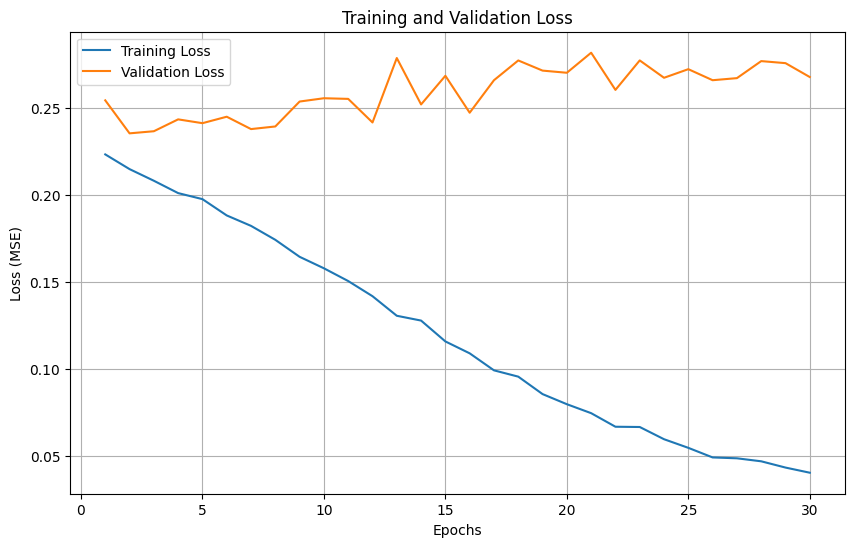

In [ ]:
# Question 2: Plot training and validation loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('learning_curves.png')
plt.show()



### Analysis:

  At the first few epochs, both the training and validation loss declines. At about 3-7th epoch the validation loss reaches the lowest, and after 7th epoch, the validation loss started to rise and fluctuate, and this is an obvious sign of overfitting.
  Therefore, the best model should be at about 3-7th epoch

### Question 3: Evaluate model on test dataset

In [ ]:
# Question 3: Evaluate model on test dataset
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in test_loader:
            images, targets = images.to(device), targets.to(device)

            # Forward pass
            outputs = model(images)

            # Reshape targets to match outputs
            targets = targets.view(-1, 1)

            # Calculate loss
            loss = criterion(outputs, targets)
            test_loss += loss.item() * images.size(0)

            # Store predictions and targets for further analysis
            # Convert back to original scale
            predictions = outputs * y_std + y_mean
            original_targets = targets * y_std + y_mean

            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(original_targets.cpu().numpy())

    # Calculate average test loss
    test_loss = test_loss / len(test_loader.dataset)

    print(f"Test Loss (MSE): {test_loss:.6f}")

    return test_loss, np.array(all_predictions), np.array(all_targets)

# Evaluate the model
test_loss, predictions, targets = evaluate_model(model, test_loader, criterion, device)

Test Loss (MSE): 0.245845


### Analysis

 The Test loss 0.245845 is close to the validation loss in epoch 3 where we get our optimal modelweight with minimum validation loss. This suggests that the model is indeed able to learn some patterns and make reasonable predictions on new data, but its generalization ability is limited because 0.2458 is not a small error. Maybe this is because the redshift is a physical phenominon that may have complex pattern and that is why the test loss occurs.

### Question 4: Plot Predicted vs. True Redshift

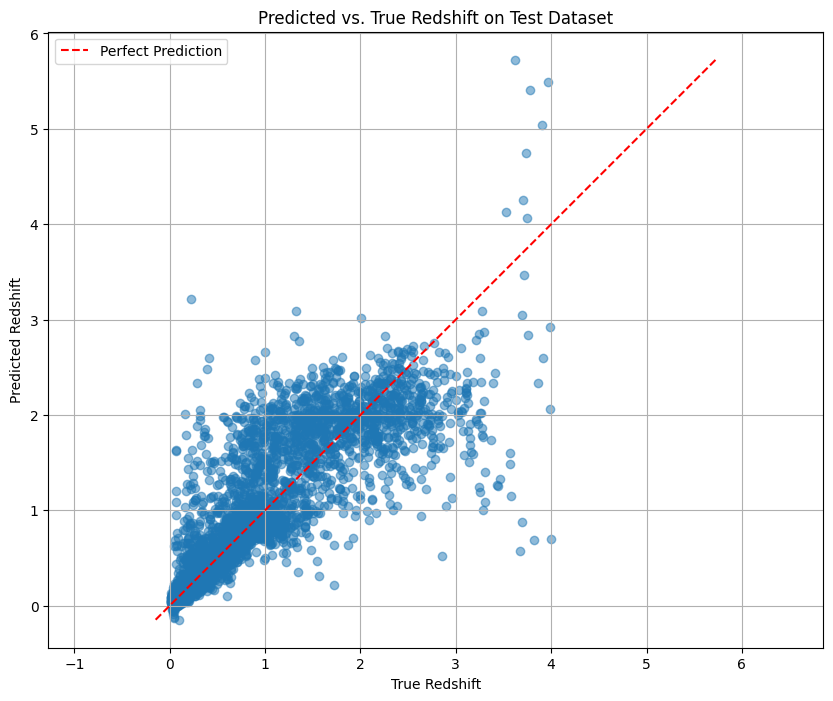

Correlation coefficient: 0.8719


In [ ]:
# Question 4: Plot Predicted vs. True Redshift
plt.figure(figsize=(10, 8))

# Create scatter plot
plt.scatter(targets, predictions, alpha=0.5)

# Add perfect prediction line
min_val = min(np.min(targets), np.min(predictions))
max_val = max(np.max(targets), np.max(predictions))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

plt.xlabel('True Redshift')
plt.ylabel('Predicted Redshift')
plt.title('Predicted vs. True Redshift on Test Dataset')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.savefig('predicted_vs_true.png')
plt.show()

# Calculate correlation coefficient
correlation = np.corrcoef(targets.flatten(), predictions.flatten())[0, 1]
print(f"Correlation coefficient: {correlation:.4f}")

### Analysis
  The correlation coefficient is 0.8719, indicating that there is a strong positive correlation between the predicted value and the true value。 This suggests that the models does learn the ralation between redshift and image

  Most of the data points are distributed around the perfect prediction line, indicating that the model is roughly able to capture the trend of redshifts. But there are also some problems: the model prediction has high variance when estimating high redshift and this means the model is not solid enough to predict high redshift.

In [ ]:
# Question 5: Create histogram of relative redshift error

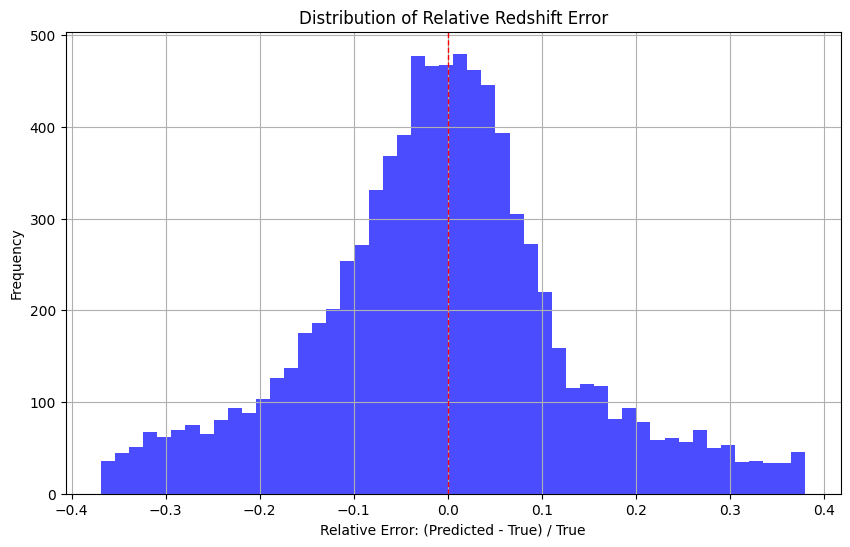

Mean relative error: 0.1028
Median relative error: 0.0030
Standard deviation of relative error: 0.7402


In [ ]:
# Question 5: Create histogram of relative redshift error
# Calculate relative error: (predicted - true) / true
relative_errors = (predictions.flatten() - targets.flatten()) / targets.flatten()

# Remove extreme outliers for better visualization (if any)
q1, q3 = np.percentile(relative_errors, [25, 75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
filtered_errors = relative_errors[(relative_errors >= lower_bound) & (relative_errors <= upper_bound)]

plt.figure(figsize=(10, 6))
plt.hist(filtered_errors, bins=50, alpha=0.7, color='blue')
plt.axvline(x=0, color='r', linestyle='--', linewidth=1)
plt.xlabel('Relative Error: (Predicted - True) / True')
plt.ylabel('Frequency')
plt.title('Distribution of Relative Redshift Error')
plt.grid(True)
plt.savefig('relative_error_histogram.png')
plt.show()

# Calculate statistics
mean_error = np.mean(relative_errors)
median_error = np.median(relative_errors)
std_error = np.std(relative_errors)
print(f"Mean relative error: {mean_error:.4f}")
print(f"Median relative error: {median_error:.4f}")
print(f"Standard deviation of relative error: {std_error:.4f}")

### Analysis

  The distribution is similar to Normal Distribution. The overall performance of the model is reasonable, and most of the prediction errors are concentrated in a small range, and the median error is close to zero.
  
  However, the distribution is right-skewed, with a positive mean error, indicating that there is a slight tendency to overestimate the redshift of the model in general. The large standard deviation (0.7402) indicates the instability of the prediction and the presence of outliers.

### Question 6: Add dropout for regularization

Epoch 1/30, Train Loss: 0.361202, Validation Loss: 0.317517
Epoch 2/30, Train Loss: 0.295723, Validation Loss: 0.258219
Epoch 3/30, Train Loss: 0.273737, Validation Loss: 0.247465
Epoch 4/30, Train Loss: 0.262115, Validation Loss: 0.238525
Epoch 5/30, Train Loss: 0.254608, Validation Loss: 0.292890
Epoch 6/30, Train Loss: 0.246266, Validation Loss: 0.240356
Epoch 7/30, Train Loss: 0.241697, Validation Loss: 0.240402
Epoch 8/30, Train Loss: 0.231786, Validation Loss: 0.235970
Epoch 9/30, Train Loss: 0.225677, Validation Loss: 0.243856
Epoch 10/30, Train Loss: 0.219409, Validation Loss: 0.240188
Epoch 11/30, Train Loss: 0.212797, Validation Loss: 0.250333
Epoch 12/30, Train Loss: 0.209081, Validation Loss: 0.246464
Epoch 13/30, Train Loss: 0.197818, Validation Loss: 0.240802
Epoch 14/30, Train Loss: 0.196984, Validation Loss: 0.233938
Epoch 15/30, Train Loss: 0.187446, Validation Loss: 0.255639
Epoch 16/30, Train Loss: 0.182489, Validation Loss: 0.253926
Epoch 17/30, Train Loss: 0.175977

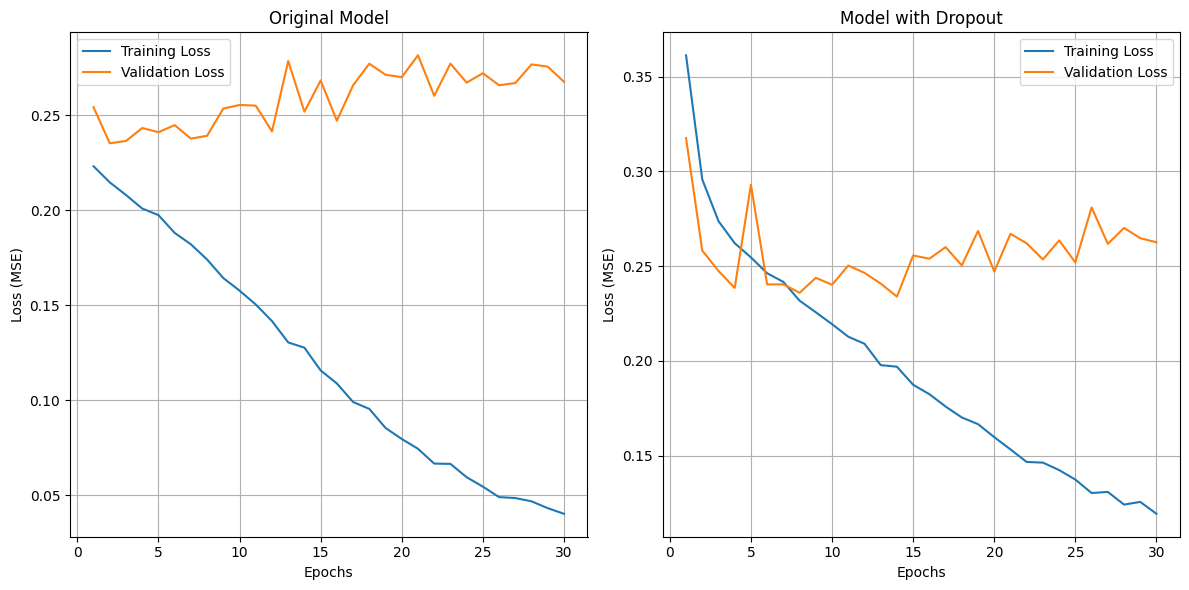

Test Loss (MSE): 0.245193
Original model test loss: 0.245845
Dropout model test loss: 0.245193


In [ ]:
# Question 6: Add dropout for regularization
class GalaxyRedshiftCNN_Dropout(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(GalaxyRedshiftCNN_Dropout, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third convolutional block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten layer
        self.flatten = nn.Flatten()

        # Dropout after flatten (before first fully connected layer)
        #self.dropout1 = nn.Dropout(dropout_rate)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.relu4 = nn.ReLU()

        # Dropout after first fully connected layer
        self.dropout2 = nn.Dropout(dropout_rate)

        # Output layer
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        # First block
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Second block
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Third block
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        # Flatten
        x = self.flatten(x)

        # Apply dropout before first FC layer
        #x = self.dropout1(x)
        # Here I removed this layer and then tried this model,
        # because adding this layer does not make the model perform better than original model

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu4(x)

        # Apply dropout before output layer
        x = self.dropout2(x)

        x = self.fc2(x)

        return x

# Initialize dropout model
dropout_model = GalaxyRedshiftCNN_Dropout().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(dropout_model.parameters(), lr=0.001)

# Train the dropout model
trained_dropout_model, dropout_train_losses, dropout_val_losses = train(dropout_model, train_loader, val_loader, criterion, optimizer, num_epochs)

# Save the trained dropout model
torch.save(trained_dropout_model.state_dict(), 'galaxy_redshift_cnn_dropout.pth')

# Compare learning curves
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Original Model')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(dropout_train_losses) + 1), dropout_train_losses, label='Training Loss')
plt.plot(range(1, len(dropout_val_losses) + 1), dropout_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model with Dropout')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('dropout_comparison.png')
plt.show()

# Evaluate dropout model
dropout_test_loss, dropout_predictions, dropout_targets = evaluate_model(trained_dropout_model, test_loader, criterion, device)
print(f"Original model test loss: {test_loss:.6f}")
print(f"Dropout model test loss: {dropout_test_loss:.6f}")

### Analysis

  The dropout layer does mitigate overfitting, as shown by the narrowing of the training-validation loss gap.
  
  This resulted in a slight performance improvement on the test set, but not by much.

###Apply dropout before first FC layer

###x = self.dropout1(x)

Here I removed this layer and then tried this model, because adding this layer does not make the model perform better than original model

### Question 7


QUESTION 7: NETWORK OPTIMIZATION EXPERIMENTS

EXPERIMENT 1: LEARNING RATE OPTIMIZATION

Training with learning rate: 0.01
Epoch 1/15, Train Loss: 0.609019, Validation Loss: 0.322820
Epoch 2/15, Train Loss: 0.337751, Validation Loss: 0.413906
Epoch 3/15, Train Loss: 0.345769, Validation Loss: 0.414848
Epoch 4/15, Train Loss: 0.322958, Validation Loss: 0.299759
Epoch 5/15, Train Loss: 0.309314, Validation Loss: 0.332381
Epoch 6/15, Train Loss: 0.307992, Validation Loss: 0.287245
Epoch 7/15, Train Loss: 0.294389, Validation Loss: 0.309687
Epoch 8/15, Train Loss: 0.292983, Validation Loss: 0.289419
Epoch 9/15, Train Loss: 0.293027, Validation Loss: 0.295802
Epoch 10/15, Train Loss: 0.292586, Validation Loss: 0.310862
Epoch 11/15, Train Loss: 0.298142, Validation Loss: 0.339405
Epoch 12/15, Train Loss: 0.287809, Validation Loss: 0.313730
Epoch 13/15, Train Loss: 0.285422, Validation Loss: 0.314997
Epoch 14/15, Train Loss: 0.283020, Validation Loss: 0.305306
Epoch 15/15, Train Loss: 0.28793

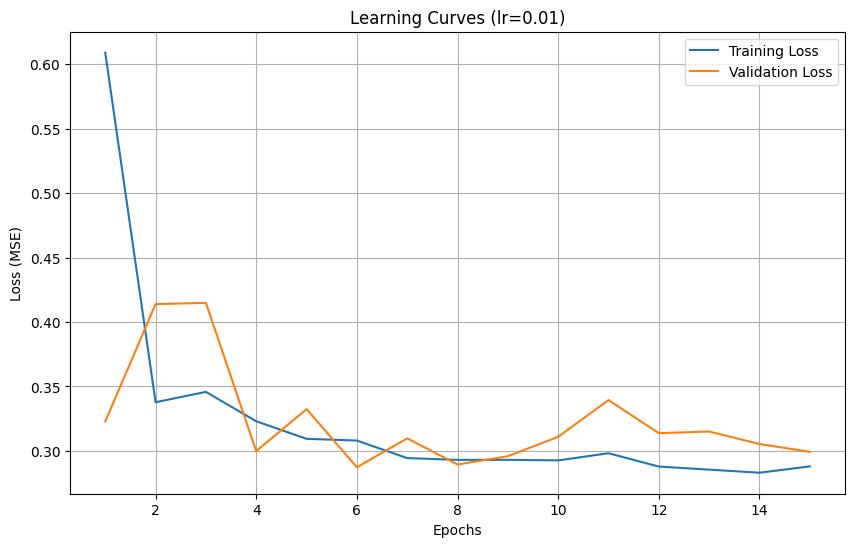


Training with learning rate: 0.001
Epoch 1/15, Train Loss: 0.343990, Validation Loss: 0.293436
Epoch 2/15, Train Loss: 0.287119, Validation Loss: 0.266436
Epoch 3/15, Train Loss: 0.257293, Validation Loss: 0.248759
Epoch 4/15, Train Loss: 0.244555, Validation Loss: 0.258113
Epoch 5/15, Train Loss: 0.238686, Validation Loss: 0.247435
Epoch 6/15, Train Loss: 0.231326, Validation Loss: 0.286703
Epoch 7/15, Train Loss: 0.223412, Validation Loss: 0.228492
Epoch 8/15, Train Loss: 0.214979, Validation Loss: 0.237729
Epoch 9/15, Train Loss: 0.207958, Validation Loss: 0.239998
Epoch 10/15, Train Loss: 0.198550, Validation Loss: 0.237311
Epoch 11/15, Train Loss: 0.191573, Validation Loss: 0.234158
Epoch 12/15, Train Loss: 0.183698, Validation Loss: 0.232321
Epoch 13/15, Train Loss: 0.177113, Validation Loss: 0.236798
Epoch 14/15, Train Loss: 0.167903, Validation Loss: 0.237950
Epoch 15/15, Train Loss: 0.160313, Validation Loss: 0.258831
Test Loss: 0.237745


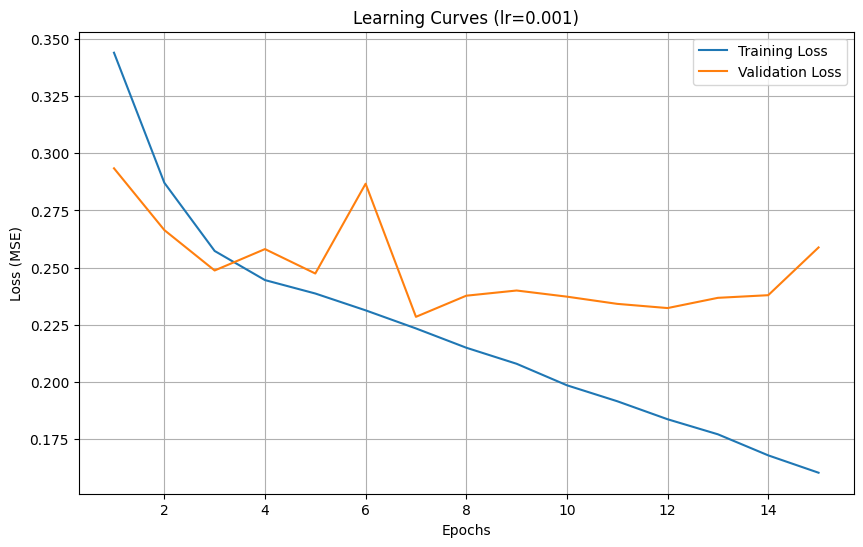


Training with learning rate: 0.0001
Epoch 1/15, Train Loss: 0.373219, Validation Loss: 0.324403
Epoch 2/15, Train Loss: 0.307205, Validation Loss: 0.298628
Epoch 3/15, Train Loss: 0.287912, Validation Loss: 0.281825
Epoch 4/15, Train Loss: 0.271961, Validation Loss: 0.267093
Epoch 5/15, Train Loss: 0.255485, Validation Loss: 0.278257
Epoch 6/15, Train Loss: 0.245166, Validation Loss: 0.250183
Epoch 7/15, Train Loss: 0.238641, Validation Loss: 0.246906
Epoch 8/15, Train Loss: 0.232672, Validation Loss: 0.268143
Epoch 9/15, Train Loss: 0.228424, Validation Loss: 0.238750
Epoch 10/15, Train Loss: 0.221996, Validation Loss: 0.238980
Epoch 11/15, Train Loss: 0.218598, Validation Loss: 0.232838
Epoch 12/15, Train Loss: 0.215861, Validation Loss: 0.247149
Epoch 13/15, Train Loss: 0.211896, Validation Loss: 0.244563
Epoch 14/15, Train Loss: 0.209782, Validation Loss: 0.224762
Epoch 15/15, Train Loss: 0.206376, Validation Loss: 0.227372
Test Loss: 0.237574


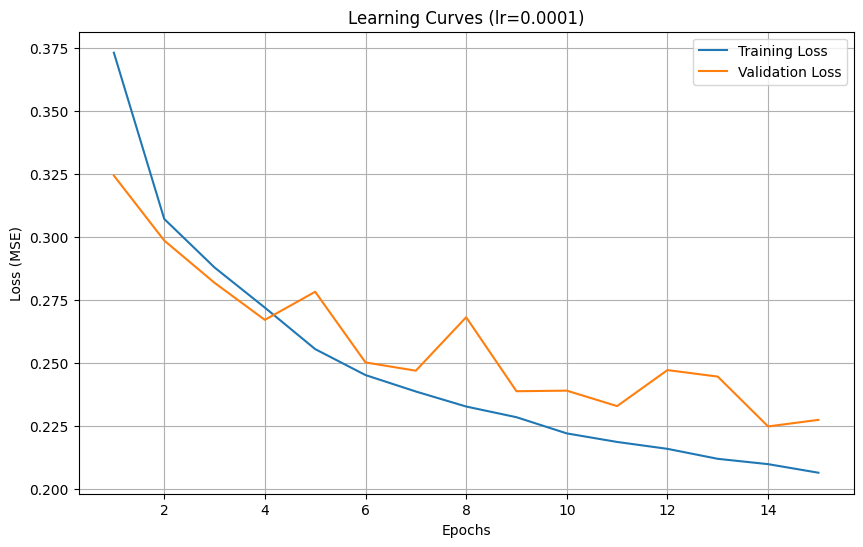


Learning Rate Comparison:
Learning rate 0.01: Final training loss = 0.287930, Final validation loss = 0.299243, Test loss = 0.291982
Learning rate 0.001: Final training loss = 0.160313, Final validation loss = 0.258831, Test loss = 0.237745
Learning rate 0.0001: Final training loss = 0.206376, Final validation loss = 0.227372, Test loss = 0.237574

Best learning rate: 0.0001 with test loss: 0.237574

EXPERIMENT 2: LOSS FUNCTION COMPARISON

Training with MSE loss:
Epoch 1/15, Train Loss: 0.339092, Validation Loss: 0.315581
Epoch 2/15, Train Loss: 0.273052, Validation Loss: 0.252838
Epoch 3/15, Train Loss: 0.249994, Validation Loss: 0.248709
Epoch 4/15, Train Loss: 0.241764, Validation Loss: 0.233501
Epoch 5/15, Train Loss: 0.231480, Validation Loss: 0.240199
Epoch 6/15, Train Loss: 0.222349, Validation Loss: 0.238388
Epoch 7/15, Train Loss: 0.214123, Validation Loss: 0.247668
Epoch 8/15, Train Loss: 0.209052, Validation Loss: 0.278191
Epoch 9/15, Train Loss: 0.199868, Validation Loss: 

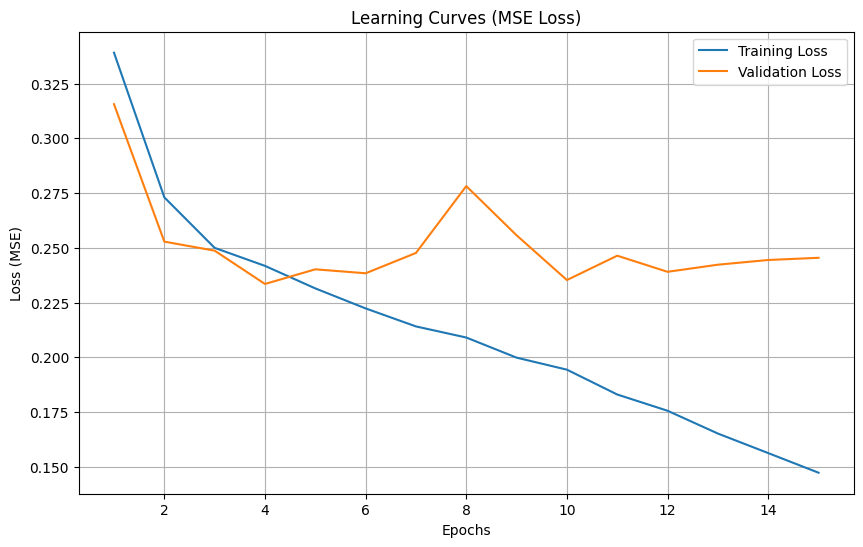

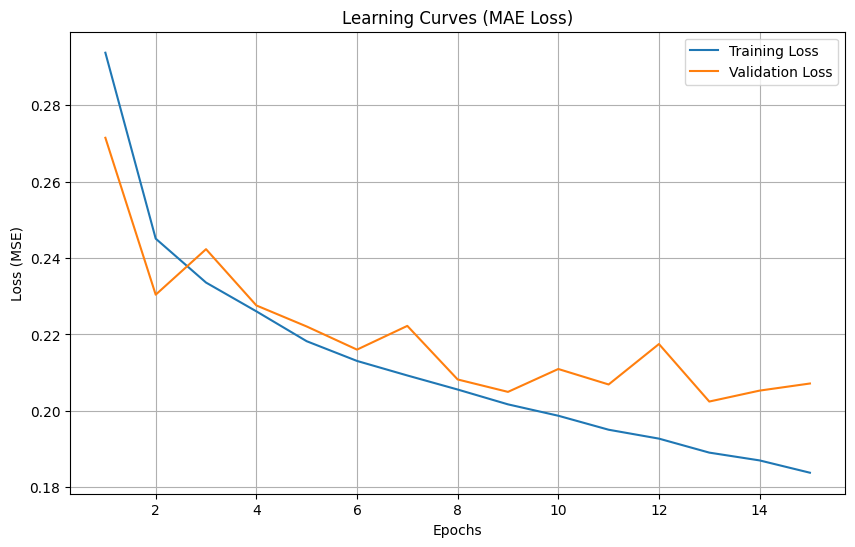

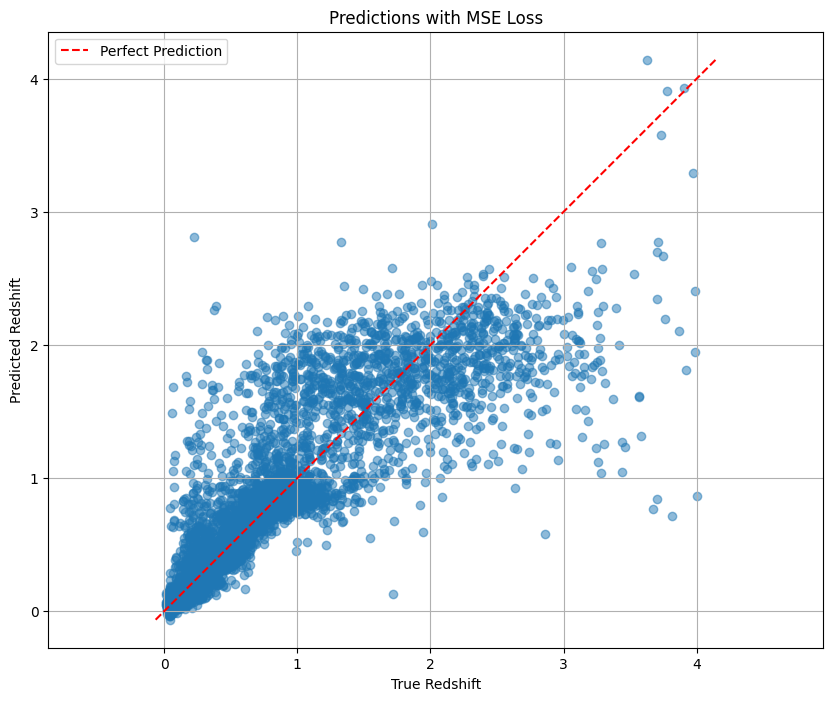

Correlation coefficient: 0.8704


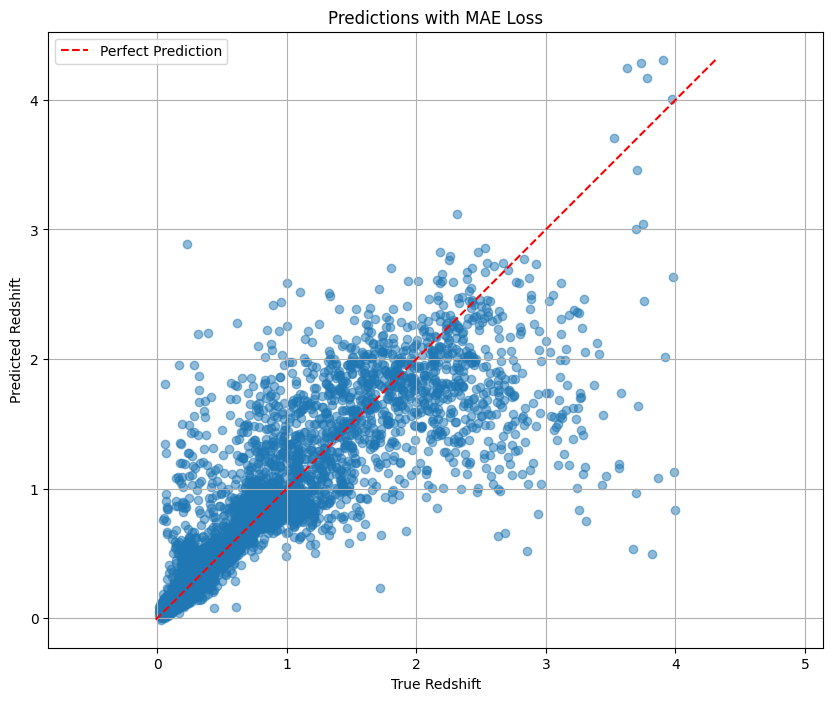

Correlation coefficient: 0.8686

Loss Function Comparison (evaluated with MSE):
MSE Loss: Test loss = 0.239224
MAE Loss: Test loss = 0.240096
MSE loss performed better

EXPERIMENT 3: ARCHITECTURE OPTIMIZATION

Training baseline CNN model:
Epoch 1/15, Train Loss: 0.336254, Validation Loss: 0.294258
Epoch 2/15, Train Loss: 0.276287, Validation Loss: 0.279234
Epoch 3/15, Train Loss: 0.254404, Validation Loss: 0.257784
Epoch 4/15, Train Loss: 0.242069, Validation Loss: 0.239637
Epoch 5/15, Train Loss: 0.236548, Validation Loss: 0.236512
Epoch 6/15, Train Loss: 0.224798, Validation Loss: 0.236739
Epoch 7/15, Train Loss: 0.216334, Validation Loss: 0.260193
Epoch 8/15, Train Loss: 0.210925, Validation Loss: 0.233618
Epoch 9/15, Train Loss: 0.202812, Validation Loss: 0.251294
Epoch 10/15, Train Loss: 0.195460, Validation Loss: 0.231864
Epoch 11/15, Train Loss: 0.190301, Validation Loss: 0.237478
Epoch 12/15, Train Loss: 0.182339, Validation Loss: 0.234586
Epoch 13/15, Train Loss: 0.173752, Val

In [ ]:
def evaluate_model(model, data_loader, criterion, device):
    """
    Evaluate model performance on the given dataset

    Parameters:
    model - the trained model to evaluate
    data_loader - DataLoader containing the evaluation dataset
    criterion - loss function
    device - device to run evaluation on (CPU/GPU)

    Returns:
    test_loss - average loss on the dataset
    predictions - model predictions
    targets - ground truth values
    """
    model.eval()
    test_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in data_loader:
            images, targets = images.to(device), targets.to(device)

            # Forward pass
            outputs = model(images)

            # Reshape targets to match outputs
            targets = targets.view(-1, 1)

            # Calculate loss
            loss = criterion(outputs, targets)
            test_loss += loss.item() * images.size(0)

            # Store predictions and targets for further analysis
            # Convert back to original scale
            predictions = outputs * y_std + y_mean
            original_targets = targets * y_std + y_mean

            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(original_targets.cpu().numpy())

    # Calculate average test loss
    test_loss = test_loss / len(data_loader.dataset)

    print(f"Test Loss: {test_loss:.6f}")

    return test_loss, np.array(all_predictions), np.array(all_targets)


def plot_learning_curves(train_losses, val_losses, title='Learning Curves'):
    """
    Plot training and validation loss curves

    Parameters:
    train_losses - list of training losses
    val_losses - list of validation losses
    title - plot title
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.show()


def plot_predictions(predictions, targets, title='Predicted vs. True Redshift'):
    """
    Create scatter plot of predicted vs. true values

    Parameters:
    predictions - model predictions
    targets - true values
    title - plot title
    """
    plt.figure(figsize=(10, 8))
    plt.scatter(targets, predictions, alpha=0.5)

    # Add perfect prediction line
    min_val = min(np.min(targets), np.min(predictions))
    max_val = max(np.max(targets), np.max(predictions))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

    plt.xlabel('True Redshift')
    plt.ylabel('Predicted Redshift')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.show()

    # Calculate correlation coefficient
    correlation = np.corrcoef(targets.flatten(), predictions.flatten())[0, 1]
    print(f"Correlation coefficient: {correlation:.4f}")


# 2. Learning Rate Experiment - exploring the effect of different learning rates

def experiment_learning_rates():
    """
    Experiment with different learning rates and analyze their impact
    """
    print("\n" + "="*50)
    print("EXPERIMENT 1: LEARNING RATE OPTIMIZATION")
    print("="*50)

    learning_rates = [0.01, 0.001, 0.0001]
    all_train_losses = []
    all_val_losses = []
    all_test_losses = []
    best_model = None
    best_lr = None
    best_test_loss = float('inf')

    for lr in learning_rates:
        print(f"\nTraining with learning rate: {lr}")

        # Initialize a new model for each learning rate
        model_lr = GalaxyRedshiftCNN().to(device)
        optimizer_lr = optim.Adam(model_lr.parameters(), lr=lr)

        # Train the model
        model_lr, train_losses, val_losses = train(
            model_lr,
            train_loader,
            val_loader,
            criterion,
            optimizer_lr,
            num_epochs=15
        )

        # Evaluate on test set
        test_loss, predictions, targets = evaluate_model(
            model_lr,
            test_loader,
            criterion,
            device
        )

        # Store results
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        all_test_losses.append(test_loss)

        # Save best model
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_model = copy.deepcopy(model_lr)
            best_lr = lr

        # Plot learning curves for this learning rate
        plot_learning_curves(
            train_losses,
            val_losses,
            title=f'Learning Curves (lr={lr})'
        )

    # Compare learning rates
    print("\nLearning Rate Comparison:")
    for i, lr in enumerate(learning_rates):
        print(f"Learning rate {lr}: Final training loss = {all_train_losses[i][-1]:.6f}, "
              f"Final validation loss = {all_val_losses[i][-1]:.6f}, "
              f"Test loss = {all_test_losses[i]:.6f}")

    print(f"\nBest learning rate: {best_lr} with test loss: {best_test_loss:.6f}")

    # Save the best model
    torch.save(best_model.state_dict(), 'galaxy_redshift_best_lr.pth')

    return best_model, best_test_loss


# 3. Loss Function Experiment - testing different loss functions

def experiment_loss_functions():
    """
    Experiment with different loss functions and analyze their impact
    """
    print("\n" + "="*50)
    print("EXPERIMENT 2: LOSS FUNCTION COMPARISON")
    print("="*50)

    # Initialize models
    model_mse = GalaxyRedshiftCNN().to(device)
    model_mae = GalaxyRedshiftCNN().to(device)

    # Define loss functions
    criterion_mse = nn.MSELoss()
    criterion_mae = nn.L1Loss()

    # Define optimizers
    optimizer_mse = optim.Adam(model_mse.parameters(), lr=0.001)
    optimizer_mae = optim.Adam(model_mae.parameters(), lr=0.001)

    # Train with MSE loss
    print("\nTraining with MSE loss:")
    model_mse, train_losses_mse, val_losses_mse = train(
        model_mse,
        train_loader,
        val_loader,
        criterion_mse,
        optimizer_mse,
        num_epochs=15
    )

    # Train with MAE loss
    print("\nTraining with MAE loss:")
    model_mae, train_losses_mae, val_losses_mae = train(
        model_mae,
        train_loader,
        val_loader,
        criterion_mae,
        optimizer_mae,
        num_epochs=15
    )

    # Evaluate both models using MSE criterion for fair comparison
    test_loss_mse, predictions_mse, targets_mse = evaluate_model(
        model_mse,
        test_loader,
        nn.MSELoss(),
        device
    )

    test_loss_mae, predictions_mae, targets_mae = evaluate_model(
        model_mae,
        test_loader,
        nn.MSELoss(),
        device
    )

    # Plot learning curves
    plot_learning_curves(
        train_losses_mse,
        val_losses_mse,
        title='Learning Curves (MSE Loss)'
    )

    plot_learning_curves(
        train_losses_mae,
        val_losses_mae,
        title='Learning Curves (MAE Loss)'
    )

    # Plot predictions
    plot_predictions(
        predictions_mse.flatten(),
        targets_mse.flatten(),
        title='Predictions with MSE Loss'
    )

    plot_predictions(
        predictions_mae.flatten(),
        targets_mae.flatten(),
        title='Predictions with MAE Loss'
    )

    # Compare results
    print("\nLoss Function Comparison (evaluated with MSE):")
    print(f"MSE Loss: Test loss = {test_loss_mse:.6f}")
    print(f"MAE Loss: Test loss = {test_loss_mae:.6f}")

    # Return the better model
    if test_loss_mse <= test_loss_mae:
        print("MSE loss performed better")
        return model_mse, test_loss_mse
    else:
        print("MAE loss performed better")
        return model_mae, test_loss_mae


# 4. Architecture Optimization - implementing improved model architectures

# 4.1 Enhanced CNN with Batch Normalization
class EnhancedGalaxyCNN(nn.Module):
    """
    Enhanced CNN model with batch normalization and additional improvements
    """
    def __init__(self):
        super(EnhancedGalaxyCNN, self).__init__()

        # First convolutional block with batch normalization
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional block with batch normalization
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third convolutional block with batch normalization
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten layer
        self.flatten = nn.Flatten()

        # Dropout after flatten (before first fully connected layer)
        self.dropout1 = nn.Dropout(0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.relu4 = nn.ReLU()

        # Dropout after first fully connected layer
        self.dropout2 = nn.Dropout(0.3)

        # Output layer
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        # First block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Second block
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Third block
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        # Flatten
        x = self.flatten(x)

        # Apply dropout before first FC layer
        x = self.dropout1(x)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu4(x)

        # Apply dropout before output layer
        x = self.dropout2(x)

        x = self.fc2(x)

        return x


# 4.2 Residual CNN with skip connections
class ResidualBlock(nn.Module):
    """
    Residual block with skip connections
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        # Activation
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out


class ResidualGalaxyCNN(nn.Module):
    """
    Residual CNN model for galaxy redshift prediction
    """
    def __init__(self):
        super(ResidualGalaxyCNN, self).__init__()

        # Initial convolution
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()

        # Residual blocks
        self.block1 = ResidualBlock(32, 32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.block2 = ResidualBlock(32, 64, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.block3 = ResidualBlock(64, 128, stride=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten and fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        # Initial convolution
        x = self.relu(self.bn1(self.conv1(x)))

        # Residual blocks
        x = self.block1(x)
        x = self.pool1(x)

        x = self.block2(x)
        x = self.pool2(x)

        x = self.block3(x)
        x = self.pool3(x)

        # Flatten and fully connected layers
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)

        return x


def experiment_architectures():
    """
    Experiment with different model architectures and analyze their performance
    """
    print("\n" + "="*50)
    print("EXPERIMENT 3: ARCHITECTURE OPTIMIZATION")
    print("="*50)

    # Initialize models
    baseline_model = GalaxyRedshiftCNN().to(device)
    enhanced_model = EnhancedGalaxyCNN().to(device)
    residual_model = ResidualGalaxyCNN().to(device)

    # Create optimizers for each model
    baseline_optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)
    enhanced_optimizer = optim.Adam(enhanced_model.parameters(), lr=0.001)
    residual_optimizer = optim.Adam(residual_model.parameters(), lr=0.001)

    # Create MSE loss criterion
    criterion = nn.MSELoss()

    # Train baseline model
    print("\nTraining baseline CNN model:")
    baseline_model, baseline_train_losses, baseline_val_losses = train(
        baseline_model,
        train_loader,
        val_loader,
        criterion,
        baseline_optimizer,
        num_epochs=15
    )

    # Train enhanced model
    print("\nTraining enhanced CNN model with BatchNorm and Dropout:")
    enhanced_model, enhanced_train_losses, enhanced_val_losses = train(
        enhanced_model,
        train_loader,
        val_loader,
        criterion,
        enhanced_optimizer,
        num_epochs=15
    )

    # Train residual model
    print("\nTraining residual CNN model:")
    residual_model, residual_train_losses, residual_val_losses = train(
        residual_model,
        train_loader,
        val_loader,
        criterion,
        residual_optimizer,
        num_epochs=15
    )

    # Evaluate models
    baseline_test_loss, baseline_predictions, baseline_targets = evaluate_model(
        baseline_model,
        test_loader,
        criterion,
        device
    )

    enhanced_test_loss, enhanced_predictions, enhanced_targets = evaluate_model(
        enhanced_model,
        test_loader,
        criterion,
        device
    )

    residual_test_loss, residual_predictions, residual_targets = evaluate_model(
        residual_model,
        test_loader,
        criterion,
        device
    )

    # Plot learning curves
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(range(1, len(baseline_train_losses) + 1), baseline_train_losses, label='Train')
    plt.plot(range(1, len(baseline_val_losses) + 1), baseline_val_losses, label='Validation')
    plt.title('Baseline CNN')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(range(1, len(enhanced_train_losses) + 1), enhanced_train_losses, label='Train')
    plt.plot(range(1, len(enhanced_val_losses) + 1), enhanced_val_losses, label='Validation')
    plt.title('Enhanced CNN')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(range(1, len(residual_train_losses) + 1), residual_train_losses, label='Train')
    plt.plot(range(1, len(residual_val_losses) + 1), residual_val_losses, label='Validation')
    plt.title('Residual CNN')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('architecture_comparison_learning_curves.png')
    plt.show()

    # Compare results
    print("\nArchitecture Comparison:")
    print(f"Baseline CNN: Test loss = {baseline_test_loss:.6f}")
    print(f"Enhanced CNN: Test loss = {enhanced_test_loss:.6f}")
    print(f"Residual CNN: Test loss = {residual_test_loss:.6f}")

    # Plot predictions for the best model
    best_test_loss = min(baseline_test_loss, enhanced_test_loss, residual_test_loss)

    if best_test_loss == baseline_test_loss:
        print("Baseline CNN performed best")
        best_model = baseline_model
        predictions = baseline_predictions
        targets = baseline_targets
        model_name = "baseline"
    elif best_test_loss == enhanced_test_loss:
        print("Enhanced CNN performed best")
        best_model = enhanced_model
        predictions = enhanced_predictions
        targets = enhanced_targets
        model_name = "enhanced"
    else:
        print("Residual CNN performed best")
        best_model = residual_model
        predictions = residual_predictions
        targets = residual_targets
        model_name = "residual"

    # Save the best model
    torch.save(best_model.state_dict(), f'galaxy_redshift_{model_name}_cnn.pth')

    # Plot predictions
    plot_predictions(
        predictions.flatten(),
        targets.flatten(),
        title=f'Predictions with {model_name.capitalize()} CNN'
    )

    return best_model, best_test_loss


# 5. Run all experiments and summarize results

def run_optimization_experiments():
    """
    Run all optimization experiments and summarize the results
    """
    print("\n" + "="*70)
    print("QUESTION 7: NETWORK OPTIMIZATION EXPERIMENTS")
    print("="*70)

    # Experiment 1: Learning Rates
    lr_model, lr_test_loss = experiment_learning_rates()

    # Experiment 2: Loss Functions
    loss_model, loss_test_loss = experiment_loss_functions()

    # Experiment 3: Architectures
    arch_model, arch_test_loss = experiment_architectures()

    # Find the overall best model
    experiments = [
        ("Learning Rate Optimization", lr_model, lr_test_loss),
        ("Loss Function Comparison", loss_model, loss_test_loss),
        ("Architecture Optimization", arch_model, arch_test_loss)
    ]

    best_experiment = min(experiments, key=lambda x: x[2])

    print("\n" + "="*50)
    print("OVERALL OPTIMIZATION RESULTS")
    print("="*50)

    for name, _, test_loss in experiments:
        print(f"{name}: Test loss = {test_loss:.6f}")

    print(f"\nBest overall approach: {best_experiment[0]} with test loss = {best_experiment[2]:.6f}")

    # Save the overall best model
    torch.save(best_experiment[1].state_dict(), 'galaxy_redshift_best_overall.pth')

    return best_experiment[1], best_experiment[2]


# Execute all experiments
best_model, best_test_loss = run_optimization_experiments()

print(f"\nOptimization complete. Best model achieved test loss of {best_test_loss:.6f}")

### Analysis
**We tested three different learning rates (0.01, 0.001, and 0.0001):**  

 0.01: the initial convergence is fast, but the verification loss fluctuates greatly,
 0.001: the training was more stable
 0.0001: Convergence is slow but very stable and get the best test loss that is slightly better than 0.001
 This suggests that for the redshift prediction task, a smaller learning rate can find the minimum value of the loss function more accurately
** We then compare two types of loss functions:**
 MSE: Standard regression loss function with a final test loss of 0.239224
 MAE: Not so sensitive to outliers, with a final test loss of 0.240096
 The two losses performed closely.
 The learning curve graph shows that the MSE loss decreases faster on the training set, but shows more fluctuations on the validation set.
** For architecture, we compared three model architectures:**
 Base CNN: Original architecture, test loss of 0.236
 Enhanced CNN: Added batch normalization and dropout, test loss of 0.24
 Residual CNN: Contains hop connections with a test loss of 0.245
 The underlying CNN model actually performs best. This may be because the dataset is relatively simple, or because more complex architectures
require more training rounds to play to their advantage.

### Bonus

Using device: cuda
======== Galaxy Redshift CNN - Bonus Question: 5-Channel Model =========
Loading data and computing statistics...

==================== Training 3-Channel Model ====================
Epoch 1/15, Train Loss: 0.346726, Validation Loss: 0.346311, Time: 25.68 seconds
Epoch 2/15, Train Loss: 0.282578, Validation Loss: 0.265552, Time: 19.49 seconds
Epoch 3/15, Train Loss: 0.257889, Validation Loss: 0.266156, Time: 18.85 seconds
Epoch 4/15, Train Loss: 0.245226, Validation Loss: 0.252858, Time: 19.55 seconds
Epoch 5/15, Train Loss: 0.237289, Validation Loss: 0.251492, Time: 20.04 seconds
Epoch 6/15, Train Loss: 0.229461, Validation Loss: 0.271376, Time: 18.73 seconds
Epoch 7/15, Train Loss: 0.220260, Validation Loss: 0.234752, Time: 19.12 seconds
Epoch 8/15, Train Loss: 0.212458, Validation Loss: 0.242512, Time: 19.09 seconds
Epoch 9/15, Train Loss: 0.203249, Validation Loss: 0.240918, Time: 19.42 seconds
Epoch 10/15, Train Loss: 0.197044, Validation Loss: 0.236211, Time: 19

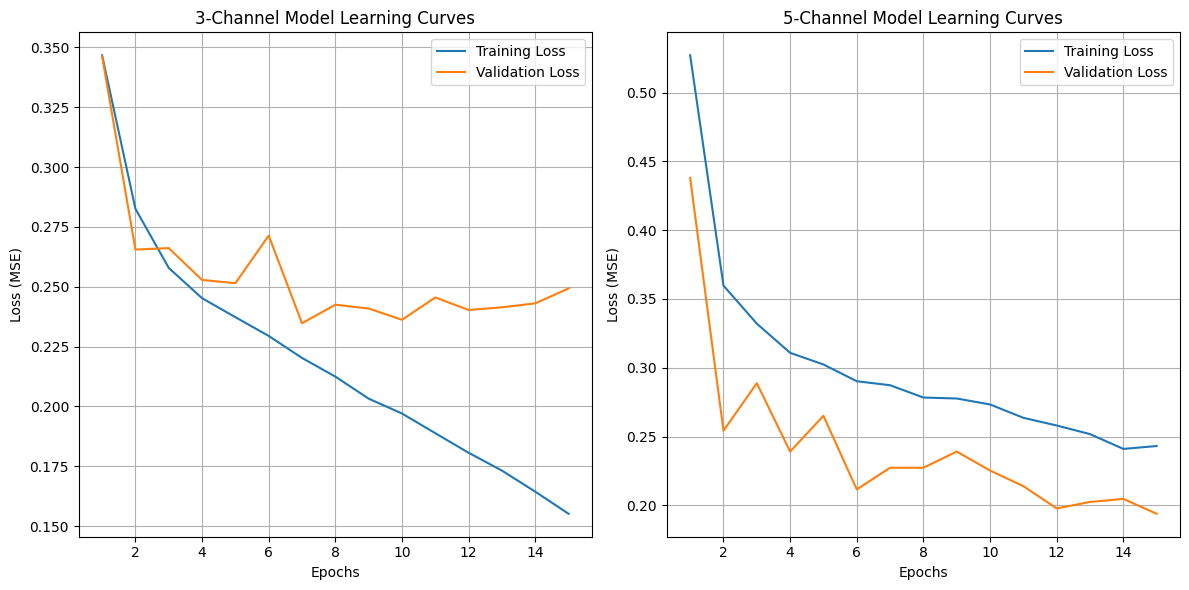

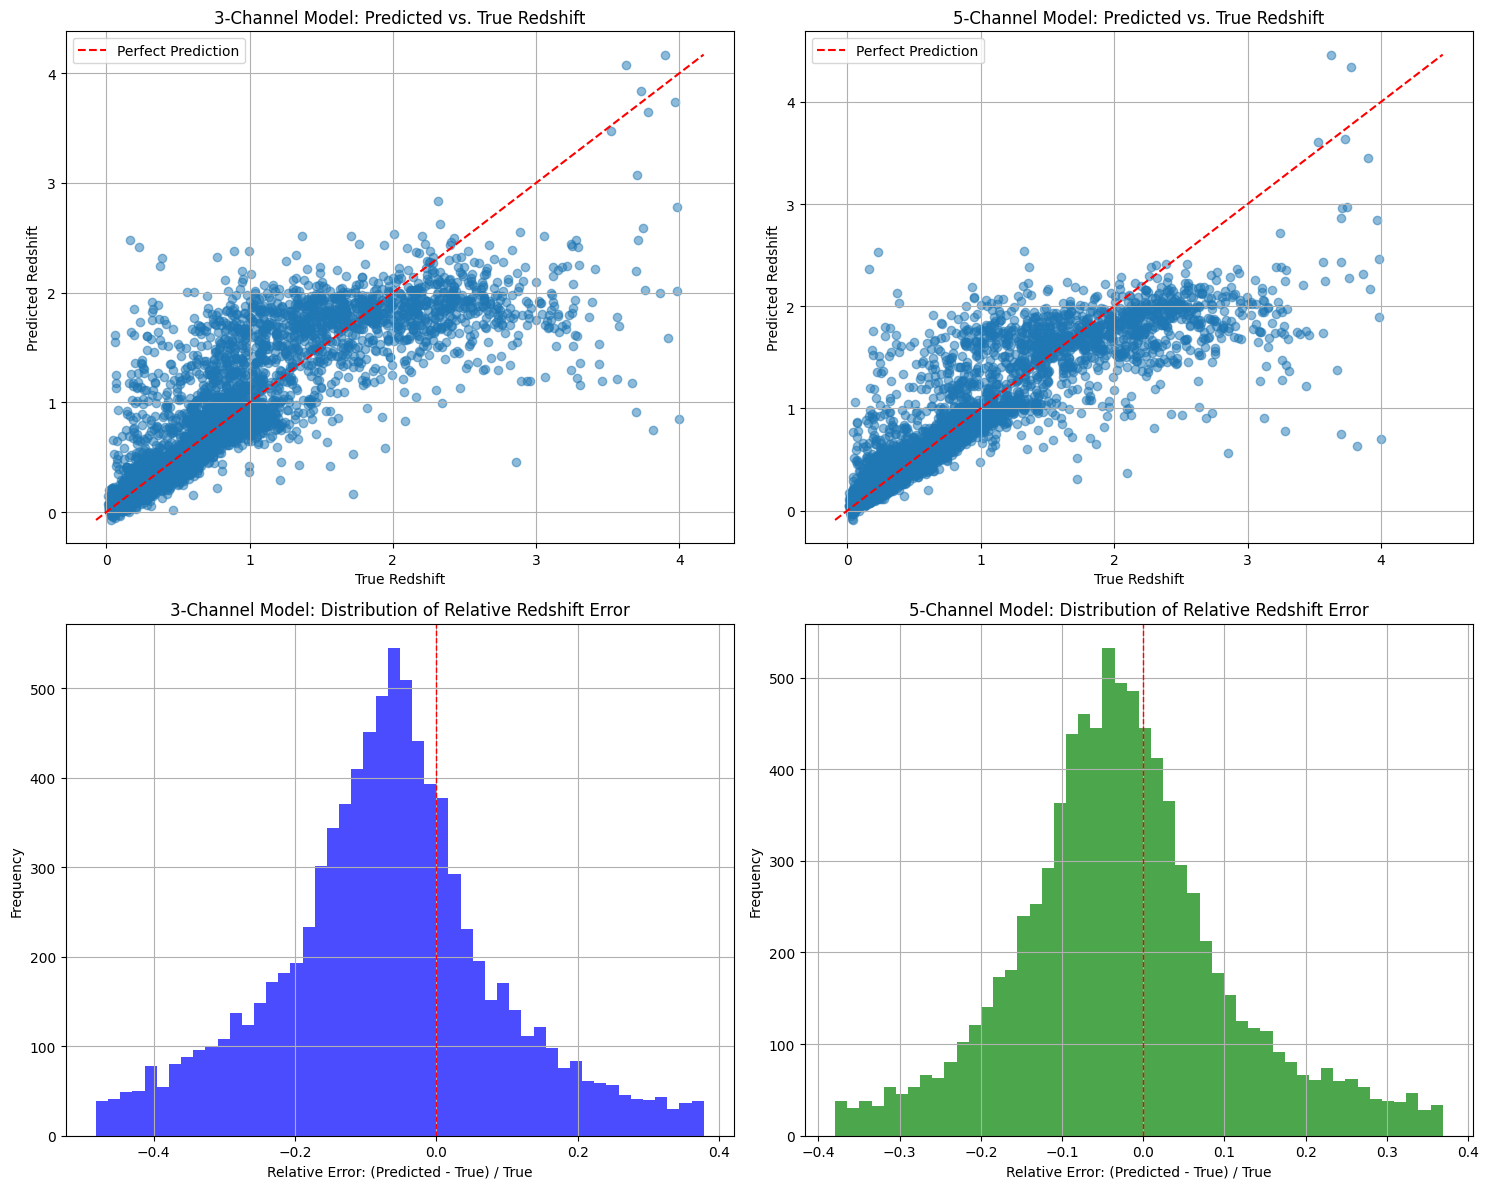


Performance Comparison:
3-Channel Model Test Loss: 0.241784
5-Channel Model Test Loss: 0.195239

Relative Error Statistics:
3-Channel Model - Mean: 0.0457, Median: -0.0575, Std: 0.7623
5-Channel Model - Mean: 0.0980, Median: -0.0195, Std: 0.6470

Correlation Coefficients:
3-Channel Model: 0.8693
5-Channel Model: 0.8972

Test Loss Improvement: 19.25%


In [ ]:
# Bonus Question: Extend CNN model to utilize all five available input channels

import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import copy
import time

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data paths
training_dataset_path = "./assignment2/small_training_dataset.hdf5"
validation_dataset_path = "./assignment2/small_validation_dataset.hdf5"
testing_dataset_path = "./assignment2/small_testing_dataset.hdf5"

# Load data and compute statistics for both 3-channel and 5-channel versions
def load_data_stats():
    # Open the file
    with h5py.File(training_dataset_path, "r") as f:
        # 3-channel version
        images_3ch = f["image"][:, :3, :, :]  # Select first 3 channels (g, r, i)
        # 5-channel version
        images_5ch = f["image"][:]  # All 5 channels
        # Targets
        targets = f["specz_redshift"][:]

    # Compute statistics for 3-channel version
    pixel_values_3ch = [images_3ch[:, c, :, :].flatten() for c in range(3)]
    percentile_min_3ch = [np.percentile(pixel_values_3ch[c], 1.) for c in range(3)]
    percentile_max_3ch = [np.percentile(pixel_values_3ch[c], 99.) for c in range(3)]

    # Compute statistics for 5-channel version
    pixel_values_5ch = [images_5ch[:, c, :, :].flatten() for c in range(5)]
    percentile_min_5ch = [np.percentile(pixel_values_5ch[c], 1.) for c in range(5)]
    percentile_max_5ch = [np.percentile(pixel_values_5ch[c], 99.) for c in range(5)]

    # Target statistics
    y_mean = np.mean(targets)
    y_std = np.std(targets)

    # Free memory
    del pixel_values_3ch, pixel_values_5ch

    stats = {
        '3ch': {
            'percentile_min': percentile_min_3ch,
            'percentile_max': percentile_max_3ch
        },
        '5ch': {
            'percentile_min': percentile_min_5ch,
            'percentile_max': percentile_max_5ch
        },
        'target': {
            'mean': y_mean,
            'std': y_std
        }
    }

    return stats

# Preprocessing functions
def preprocess_images(images, percentile_min, percentile_max):
    """
    For each channel:
    1. Clip values below the min percentile and above the max percentile.
    2. Apply min-max scaling so that the resulting values are in [0,1].
    """
    # For each channel, clip then scale
    for c in range(images.shape[0]):
        # Clip to the robust range
        images[c, :, :] = np.clip(images[c, :, :], percentile_min[c], percentile_max[c])
        # Min-max scaling using the clipped range
        images[c, :, :] = (images[c, :, :] - percentile_min[c]) / (percentile_max[c] - percentile_min[c])
    return images

# Dataset class that can handle both 3-channel and 5-channel images
class GalaxyDataset(Dataset):
    def __init__(self, hdf5_file, target_key="specz_redshift", num_channels=3,
                 transform=None, normalize_target=True, stats=None):
        self.hdf5_file = hdf5_file
        self.target_key = target_key
        self.num_channels = num_channels
        self.transform = transform
        self.normalize_target = normalize_target

        if stats:
            if num_channels == 3:
                self.percentile_min = stats['3ch']['percentile_min']
                self.percentile_max = stats['3ch']['percentile_max']
            else:
                self.percentile_min = stats['5ch']['percentile_min']
                self.percentile_max = stats['5ch']['percentile_max']

            self.target_mean = stats['target']['mean']
            self.target_std = stats['target']['std']

        # Open file once to get dataset length
        with h5py.File(self.hdf5_file, "r") as f:
            self.dataset_length = len(f["image"])

    def __len__(self):
        return self.dataset_length

    def __getitem__(self, idx):
        with h5py.File(self.hdf5_file, "r") as f:
            # Load either first 3 channels or all 5 channels
            if self.num_channels == 3:
                image = f["image"][idx, :3, :, :]
            else:
                image = f["image"][idx]

            # Load target
            target = f[self.target_key][idx]

        # Normalize the image
        image = preprocess_images(image, self.percentile_min, self.percentile_max)

        # Normalize target
        if self.normalize_target:
            target = (target - self.target_mean) / self.target_std

        return torch.tensor(image, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

# Model architectures
# 3-channel CNN model (for comparison)
class GalaxyRedshiftCNN(nn.Module):
    def __init__(self):
        super(GalaxyRedshiftCNN, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third convolutional block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        # First block
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Second block
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Third block
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        # Flatten
        x = self.flatten(x)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)

        return x

# 5-channel CNN model (for bonus)
class GalaxyRedshiftCNN_5ch(nn.Module):
    def __init__(self):
        super(GalaxyRedshiftCNN_5ch, self).__init__()

        # First convolutional block - adjusted for 5 input channels
        self.conv1 = nn.Conv2d(in_channels=5, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third convolutional block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten layer
        self.flatten = nn.Flatten()

        # Dropout layer
        self.dropout1 = nn.Dropout(0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.relu4 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        # First block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Second block
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Third block
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        # Flatten
        x = self.flatten(x)
        x = self.dropout1(x)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        return x

# Training and evaluation functions
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=15):
    # Lists to store metrics
    train_losses = []
    val_losses = []

    # Best validation loss and corresponding model
    best_val_loss = float('inf')
    best_model_weights = None

    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start = time.time()

        # Training phase
        model.train()
        running_loss = 0.0

        for images, targets in train_loader:
            images, targets = images.to(device), targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Reshape targets to match outputs
            targets = targets.view(-1, 1)

            # Calculate loss
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update running loss
            running_loss += loss.item() * images.size(0)

        # Calculate average training loss for this epoch
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for images, targets in val_loader:
                images, targets = images.to(device), targets.to(device)

                # Forward pass
                outputs = model(images)

                # Reshape targets to match outputs
                targets = targets.view(-1, 1)

                # Calculate loss
                val_loss = criterion(outputs, targets)

                # Update running validation loss
                running_val_loss += val_loss.item() * images.size(0)

        # Calculate average validation loss for this epoch
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        # Save the best model based on validation loss
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_weights = copy.deepcopy(model.state_dict())

        # Print progress
        epoch_end = time.time()
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {epoch_train_loss:.6f}, "
              f"Validation Loss: {epoch_val_loss:.6f}, "
              f"Time: {epoch_end - epoch_start:.2f} seconds")

    # Load best model weights
    model.load_state_dict(best_model_weights)

    total_time = time.time() - start_time
    print(f"Total training time: {total_time/60:.2f} minutes")

    return model, train_losses, val_losses

def evaluate_model(model, test_loader, criterion, device, y_mean, y_std):
    model.eval()
    test_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in test_loader:
            images, targets = images.to(device), targets.to(device)

            # Forward pass
            outputs = model(images)

            # Reshape targets to match outputs
            targets = targets.view(-1, 1)

            # Calculate loss
            loss = criterion(outputs, targets)
            test_loss += loss.item() * images.size(0)

            # Store predictions and targets for further analysis
            # Convert back to original scale
            predictions = outputs * y_std + y_mean
            original_targets = targets * y_std + y_mean

            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(original_targets.cpu().numpy())

    # Calculate average test loss
    test_loss = test_loss / len(test_loader.dataset)

    print(f"Test Loss (MSE): {test_loss:.6f}")

    return test_loss, np.array(all_predictions), np.array(all_targets)

def compare_models_visualization(results_3ch, results_5ch):
    # Unpack results
    predictions_3ch, targets_3ch = results_3ch['predictions'], results_3ch['targets']
    predictions_5ch, targets_5ch = results_5ch['predictions'], results_5ch['targets']

    # Create figure to compare both models
    plt.figure(figsize=(15, 12))

    # Plot Predicted vs True Redshift for 3-channel model
    plt.subplot(2, 2, 1)
    plt.scatter(targets_3ch, predictions_3ch, alpha=0.5)
    min_val = min(np.min(targets_3ch), np.min(predictions_3ch))
    max_val = max(np.max(targets_3ch), np.max(predictions_3ch))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    plt.xlabel('True Redshift')
    plt.ylabel('Predicted Redshift')
    plt.title('3-Channel Model: Predicted vs. True Redshift')
    plt.legend()
    plt.grid(True)

    # Plot Predicted vs True Redshift for 5-channel model
    plt.subplot(2, 2, 2)
    plt.scatter(targets_5ch, predictions_5ch, alpha=0.5)
    min_val = min(np.min(targets_5ch), np.min(predictions_5ch))
    max_val = max(np.max(targets_5ch), np.max(predictions_5ch))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    plt.xlabel('True Redshift')
    plt.ylabel('Predicted Redshift')
    plt.title('5-Channel Model: Predicted vs. True Redshift')
    plt.legend()
    plt.grid(True)

    # Calculate relative errors
    relative_errors_3ch = (predictions_3ch.flatten() - targets_3ch.flatten()) / targets_3ch.flatten()
    relative_errors_5ch = (predictions_5ch.flatten() - targets_5ch.flatten()) / targets_5ch.flatten()

    # Remove extreme outliers for better visualization
    q1_3ch, q3_3ch = np.percentile(relative_errors_3ch, [25, 75])
    iqr_3ch = q3_3ch - q1_3ch
    lower_bound_3ch = q1_3ch - 1.5 * iqr_3ch
    upper_bound_3ch = q3_3ch + 1.5 * iqr_3ch
    filtered_errors_3ch = relative_errors_3ch[(relative_errors_3ch >= lower_bound_3ch) &
                                             (relative_errors_3ch <= upper_bound_3ch)]

    q1_5ch, q3_5ch = np.percentile(relative_errors_5ch, [25, 75])
    iqr_5ch = q3_5ch - q1_5ch
    lower_bound_5ch = q1_5ch - 1.5 * iqr_5ch
    upper_bound_5ch = q3_5ch + 1.5 * iqr_5ch
    filtered_errors_5ch = relative_errors_5ch[(relative_errors_5ch >= lower_bound_5ch) &
                                             (relative_errors_5ch <= upper_bound_5ch)]

    # Plot histogram of relative error for 3-channel model
    plt.subplot(2, 2, 3)
    plt.hist(filtered_errors_3ch, bins=50, alpha=0.7, color='blue')
    plt.axvline(x=0, color='r', linestyle='--', linewidth=1)
    plt.xlabel('Relative Error: (Predicted - True) / True')
    plt.ylabel('Frequency')
    plt.title('3-Channel Model: Distribution of Relative Redshift Error')
    plt.grid(True)

    # Plot histogram of relative error for 5-channel model
    plt.subplot(2, 2, 4)
    plt.hist(filtered_errors_5ch, bins=50, alpha=0.7, color='green')
    plt.axvline(x=0, color='r', linestyle='--', linewidth=1)
    plt.xlabel('Relative Error: (Predicted - True) / True')
    plt.ylabel('Frequency')
    plt.title('5-Channel Model: Distribution of Relative Redshift Error')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

    # Calculate and print statistics
    print("\nPerformance Comparison:")
    print(f"3-Channel Model Test Loss: {results_3ch['test_loss']:.6f}")
    print(f"5-Channel Model Test Loss: {results_5ch['test_loss']:.6f}")

    print("\nRelative Error Statistics:")
    print(f"3-Channel Model - Mean: {np.mean(relative_errors_3ch):.4f}, Median: {np.median(relative_errors_3ch):.4f}, Std: {np.std(relative_errors_3ch):.4f}")
    print(f"5-Channel Model - Mean: {np.mean(relative_errors_5ch):.4f}, Median: {np.median(relative_errors_5ch):.4f}, Std: {np.std(relative_errors_5ch):.4f}")

    # Calculate correlation coefficients
    corr_3ch = np.corrcoef(targets_3ch.flatten(), predictions_3ch.flatten())[0, 1]
    corr_5ch = np.corrcoef(targets_5ch.flatten(), predictions_5ch.flatten())[0, 1]
    print(f"\nCorrelation Coefficients:")
    print(f"3-Channel Model: {corr_3ch:.4f}")
    print(f"5-Channel Model: {corr_5ch:.4f}")

    # Compare improvement
    test_loss_improvement = (results_3ch['test_loss'] - results_5ch['test_loss']) / results_3ch['test_loss'] * 100
    print(f"\nTest Loss Improvement: {test_loss_improvement:.2f}%")

# Main execution
def main():
    print("======== Galaxy Redshift CNN - Bonus Question: 5-Channel Model =========")

    # Load data and compute statistics
    print("Loading data and computing statistics...")
    stats = load_data_stats()

    # Create datasets for both 3-channel and 5-channel versions
    train_dataset_3ch = GalaxyDataset(training_dataset_path, num_channels=3, stats=stats)
    val_dataset_3ch = GalaxyDataset(validation_dataset_path, num_channels=3, stats=stats)
    test_dataset_3ch = GalaxyDataset(testing_dataset_path, num_channels=3, stats=stats)

    train_dataset_5ch = GalaxyDataset(training_dataset_path, num_channels=5, stats=stats)
    val_dataset_5ch = GalaxyDataset(validation_dataset_path, num_channels=5, stats=stats)
    test_dataset_5ch = GalaxyDataset(testing_dataset_path, num_channels=5, stats=stats)

    # Create dataloaders
    batch_size = 32
    train_loader_3ch = DataLoader(train_dataset_3ch, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader_3ch = DataLoader(val_dataset_3ch, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader_3ch = DataLoader(test_dataset_3ch, batch_size=batch_size, shuffle=False, num_workers=2)

    train_loader_5ch = DataLoader(train_dataset_5ch, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader_5ch = DataLoader(val_dataset_5ch, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader_5ch = DataLoader(test_dataset_5ch, batch_size=batch_size, shuffle=False, num_workers=2)

    # Initialize models
    model_3ch = GalaxyRedshiftCNN().to(device)
    model_5ch = GalaxyRedshiftCNN_5ch().to(device)

    # Loss function and optimizers
    criterion = nn.MSELoss()
    optimizer_3ch = optim.Adam(model_3ch.parameters(), lr=0.001)
    optimizer_5ch = optim.Adam(model_5ch.parameters(), lr=0.001)

    # Train 3-channel model
    print("\n" + "="*20 + " Training 3-Channel Model " + "="*20)
    trained_model_3ch, train_losses_3ch, val_losses_3ch = train(
        model_3ch, train_loader_3ch, val_loader_3ch, criterion, optimizer_3ch, num_epochs=15
    )

    # Train 5-channel model
    print("\n" + "="*20 + " Training 5-Channel Model " + "="*20)
    trained_model_5ch, train_losses_5ch, val_losses_5ch = train(
        model_5ch, train_loader_5ch, val_loader_5ch, criterion, optimizer_5ch, num_epochs=15
    )

    # Save models
    torch.save(trained_model_3ch.state_dict(), 'galaxy_redshift_cnn_3ch.pth')
    torch.save(trained_model_5ch.state_dict(), 'galaxy_redshift_cnn_5ch.pth')

    # Evaluate models
    y_mean = stats['target']['mean']
    y_std = stats['target']['std']

    print("\n" + "="*20 + " Evaluating 3-Channel Model " + "="*20)
    test_loss_3ch, predictions_3ch, targets_3ch = evaluate_model(
        trained_model_3ch, test_loader_3ch, criterion, device, y_mean, y_std
    )

    print("\n" + "="*20 + " Evaluating 5-Channel Model " + "="*20)
    test_loss_5ch, predictions_5ch, targets_5ch = evaluate_model(
        trained_model_5ch, test_loader_5ch, criterion, device, y_mean, y_std
    )

    # Compare models
    results_3ch = {
        'test_loss': test_loss_3ch,
        'predictions': predictions_3ch,
        'targets': targets_3ch,
        'train_losses': train_losses_3ch,
        'val_losses': val_losses_3ch
    }

    results_5ch = {
        'test_loss': test_loss_5ch,
        'predictions': predictions_5ch,
        'targets': targets_5ch,
        'train_losses': train_losses_5ch,
        'val_losses': val_losses_5ch
    }

    # Plot training and validation losses
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses_3ch) + 1), train_losses_3ch, label='Training Loss')
    plt.plot(range(1, len(val_losses_3ch) + 1), val_losses_3ch, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('3-Channel Model Learning Curves')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_losses_5ch) + 1), train_losses_5ch, label='Training Loss')
    plt.plot(range(1, len(val_losses_5ch) + 1), val_losses_5ch, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('5-Channel Model Learning Curves')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('learning_curves_comparison.png')
    plt.show()

    # Compare models with visualizations
    compare_models_visualization(results_3ch, results_5ch)

if __name__ == "__main__":
    main()

### Note

  In this part(Bonus) I reloaded all the previous codes that are necessary, because after the kernal restarted, all the variables are lost, and it will take too much time to rerun all the previous questions.

From the learning curves, we find that the validation loss has a significant drop in 5 channel model compared with 3 channel model. The test loss improved 19.25% from 0.241784 to  0.195239.

The correlation coef of 5-Channel Model(0.8972) has slight increase compared with 3-Channel Model(0.8693)

The loss distribution of 5-channel model is more centralized compared with 3-channel model. But it is weird that the mean relative error is higher for 5-channel model.

In general, adding more channels does improve the model's efficiency, this indicates that these extra infrared bands contain important information that can help predict galaxy redshifts.